In [1]:
import pandas as pd
import datetime
from astropy.time import Time
import spiceypy as spy
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
from Utils import *
from astroquery.jplhorizons import Horizons
import spiceypy as spy

In [2]:
fireballs = pd.read_csv('datos/cneos_fireball_data_original.csv', comment='#')
fireballs

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt)
0,2023-08-05 19:54:50,19.9N,131.7W,44.0,21.8,3.3,20.4,-6.8,1.719000e+12,3.800
1,2023-07-26 03:41:54,18.9N,103.4W,36.1,15.6,-9.5,12.2,1.9,1.510000e+11,0.440
2,2023-07-07 16:15:31,14.5N,126.6W,38.3,25.7,2.6,4.1,-25.2,2.600000e+10,0.092
3,2023-07-06 05:52:31,59.3S,145.4W,71.0,NaN,NaN,NaN,NaN,3.000000e+10,0.100
4,2023-06-21 19:39:13,12.4N,62.8E,40.4,16.5,7.3,-2.0,-16.4,5.430000e+11,1.400
...,...,...,...,...,...,...,...,...,...,...
955,1993-11-29 17:48:41,26.5N,78.3E,NaN,NaN,NaN,NaN,NaN,2.600000e+10,0.092
956,1993-10-31 03:39:27,51.3N,100.9W,NaN,NaN,NaN,NaN,NaN,4.000000e+10,0.130
957,1991-10-04 09:22:47,78.7N,6.3E,NaN,NaN,NaN,NaN,NaN,5.500000e+11,1.400
958,1990-10-01 03:51:47,7.5N,142.8E,NaN,NaN,NaN,NaN,NaN,2.500000e+12,5.200


In [3]:
fireballs = fireballs.dropna()


In [4]:
def change_coord(x):
    if x[-1] == 'N' or x[-1] == 'E':
        new = float(x[:-1])
    elif x[-1] == 'S' or x[-1] == 'W':
        new = -float(x[:-1])
    return new    

In [5]:
fireballs['Longitude (deg.)'] = fireballs['Longitude (deg.)'].apply(change_coord)
fireballs['Latitude (deg.)'] = fireballs['Latitude (deg.)'].apply(change_coord)


C:\Users\aguju\AppData\Local\Temp\ipykernel_31072\2173166978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['Longitude (deg.)'] = fireballs['Longitude (deg.)'].apply(change_coord)
C:\Users\aguju\AppData\Local\Temp\ipykernel_31072\2173166978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['Latitude (deg.)'] = fireballs['Latitude (deg.)'].apply(change_coord)


In [ ]:
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls -O naif0012.tls
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/pck00010.tpc -O pck00010.tpc
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_fixed.tf -O earth_fixed.tf
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_720101_230601.bpc -O earth_720101_230601.bpc
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de438.bsp -O de438.bsp
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_latest_high_prec.bpc -O earth_latest_high_prec.bpc


'wget' is not recognized as an internal or external command,
operable program or batch file.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
spy.furnsh(['naif0012.tls', 'pck00010.tpc', 'earth_fixed.tf', 'earth_720101_230601.bpc', 'de438.bsp', 'earth_latest_high_prec.bpc'])

SpiceNOSUCHFILE: 
================================================================================

Toolkit version: CSPICE_N0067

SPICE(NOSUCHFILE) --

The attempt to load "naif0012.tls" by the routine FURNSH failed. It could not be located.

furnsh_c --> FURNSH --> ZZLDKER

================================================================================

### get earth sun SSB positions

In [18]:
earthxyz=np.zeros((len(fireballs),3))
sunxyz=np.zeros((len(fireballs),3))

earthvxyz=np.zeros((len(fireballs),3))
sunvxyz=np.zeros((len(fireballs),3))

In [19]:
for i, date in enumerate(fireballs['Peak Brightness Date/Time (UT)']):
    start =  datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    stop = start + datetime.timedelta(minutes=1)

    sun = Horizons(id = '10', location='@0', epochs = dict(start = str(start), stop = str(stop), step = '1m')).vectors()
    earth = Horizons(id = '399', location='@0', epochs = dict(start = str(start), stop = str(stop), step = '1m')).vectors()

    earthxyz[i] = [earth[0]['x'], earth[0]['y'],earth[0]['z']]
    sunxyz[i] = [sun[0]['x'], sun[0]['y'], sun[0]['z']]

    earthvxyz[i] = [earth[0]['vx'], earth[0]['vy'],earth[0]['vz']]
    sunvxyz[i] = [sun[0]['vx'], sun[0]['vy'], sun[0]['vz']]



In [20]:
UA2km = 1.496e+8
day2sec = 86400

In [21]:
fireballs['earthx'] = earthxyz[:,0]*UA2km
fireballs['earthy'] = earthxyz[:,1]*UA2km
fireballs['earthz'] = earthxyz[:,2]*UA2km

fireballs['sunx'] = sunxyz[:,0]*UA2km
fireballs['suny'] = sunxyz[:,1]*UA2km
fireballs['sunz'] = sunxyz[:,2]*UA2km

fireballs['earthvx'] = earthvxyz[:,0]*UA2km/day2sec
fireballs['earthvy'] = earthvxyz[:,1]*UA2km/day2sec
fireballs['earthvz'] = earthvxyz[:,2]*UA2km/day2sec

fireballs['sunvx'] = sunvxyz[:,0]*UA2km/day2sec
fireballs['sunvy'] = sunvxyz[:,1]*UA2km/day2sec
fireballs['sunvz'] = sunvxyz[:,2]*UA2km/day2sec



/tmp/ipykernel_25315/2521466836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['earthx'] = earthxyz[:,0]*UA2km
/tmp/ipykernel_25315/2521466836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['earthy'] = earthxyz[:,1]*UA2km
/tmp/ipykernel_25315/2521466836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [17]:
#fireballs.to_csv('cneos_fireball_data_sun_earth.csv', index = False)

### Integrate positions for all bodies

In [22]:
#fireballs = pd.read_csv('cneos_fireball_data_sun_earth.csv')
#fireballs = fireballs[:10]
meteor = fireballs.loc[fireballs['Peak Brightness Date/Time (UT)'].str.contains('2014-01-08 17:05:34')]

In [23]:
meteor

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt),...,earthz,sunx,suny,sunz,earthvx,earthvy,earthvz,sunvx,sunvy,sunvz
355,2014-01-08 17:05:34,-1.3,147.6,18.7,44.8,-3.4,-43.5,-10.3,3.100000e+10,0.11,...,-18427.0739,154507.425703,-338061.540911,-14068.661556,-28.77745,-9.396459,0.001138,0.010447,0.004187,-0.000242


In [24]:

date = fireballs['Peak Brightness Date/Time (UT)'].to_numpy()
lon = fireballs['Longitude (deg.)'].to_numpy()
lat = fireballs['Latitude (deg.)'].to_numpy()
alt = fireballs['Altitude (km)'].to_numpy()
vx = fireballs['vx'].to_numpy()
vy = fireballs['vy'].to_numpy()
vz = fireballs['vz'].to_numpy()

In [25]:
T_earth = 86400

#vector velocidad de rotación
omega = np.array([0,0,(2*np.pi)/T_earth]) 

r_eclip = []
v_eclip = []
for i in range(len(lon)):
    r = Geo2Rec(lon[i], lat[i], alt[i])
    v = [vx[i], vy[i], vz[i]]
    v_E = (v - spy.vcrss(omega, r))
    et = spy.utc2et(date[i])
    mx = spy.pxform('IAU_EARTH', 'ECLIPJ2000', et)

    r_eclip.append(spy.mxv(mx, r))
    v_eclip.append(spy.mxv(mx, v_E))
    


In [26]:
r_eclip  = np.array(r_eclip)
v_eclip  = np.array(v_eclip)
r_eclip, v_eclip

(array([[-3.08244248e+03,  5.63084925e+03, -6.58856623e+01],
        [-1.53770701e+03, -4.56420363e+03,  4.23289137e+03],
        [ 4.60112273e+03,  4.46543698e+03, -2.07684868e+02],
        [-3.28425133e+02, -5.19938713e+03,  3.74747456e+03],
        [-6.01437538e+03, -1.73908870e+03, -1.35234915e+03],
        [ 3.26633348e+03,  4.53726086e+03,  3.10765700e+03],
        [ 6.00841079e+03, -4.55872836e+02, -2.20668261e+03],
        [-3.34741453e+03,  2.90599965e+03,  4.60822389e+03],
        [-5.16202252e+02, -6.37361652e+03,  7.48665365e+02],
        [ 1.77962886e+03, -2.56976453e+03,  5.58623039e+03],
        [ 6.30022986e+03, -4.32122164e+02,  1.12659266e+03],
        [ 1.11018466e+03,  1.91947618e+03, -6.00217374e+03],
        [ 3.70315513e+03,  4.97030699e+03,  1.63345671e+03],
        [-3.46703153e+03,  5.20628774e+03,  1.38165413e+03],
        [-6.13334063e+02, -5.88776511e+03, -2.41747627e+03],
        [ 1.88644777e+03, -2.29636430e+03,  5.66905633e+03],
        [ 5.11304561e+03

In [27]:
fireballs['x_ecliptic'] = r_eclip[:,0]
fireballs['y_ecliptic'] = r_eclip[:,1]
fireballs['z_ecliptic'] = r_eclip[:,2]

fireballs['vx_ecliptic'] = v_eclip[:,0]
fireballs['vy_ecliptic'] = v_eclip[:,1]
fireballs['vz_ecliptic'] = v_eclip[:,2]

/tmp/ipykernel_25315/2424671013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['x_ecliptic'] = r_eclip[:,0]
/tmp/ipykernel_25315/2424671013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fireballs['y_ecliptic'] = r_eclip[:,1]
/tmp/ipykernel_25315/2424671013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [29]:
fireballs.to_csv('cneos_fireball_data_sun_earth.csv', index = False)

In [59]:
positions = []
e = []
q = [] 
inc = []

for i in range(len(r_eclip)):
    sim = rb.Simulation()
    sim.units = 'km', 's', 'kg'
    sim.integrator = "WHFast"
    sim.dt = 86400
    time = -3.154e+7

    #sun = sim.add("Sun", hash='sun', date=date[i])
    #earth = sim.add("Earth", hash='earth', date=date[i])

    #r_earth = np.array(sim.particles['earth'].xyz)
    #v_earth = np.array(sim.particles['earth'].vxyz)

    earth = sim.add(x=fireballs['earthx (km)'][i], y=fireballs['earthy (km)'][i], z=fireballs['earthz (km)'][i], 
                   vx=fireballs['earthvx (km/s)'][i], vy=fireballs['earthvy (km/s)'][i], vz=fireballs['earthvz (km/s)'][i], m=5.9722e24)
    sun = sim.add(x=fireballs['sunx (km)'][i], y=fireballs['suny (km)'][i], z=fireballs['sunz (km)'][i], 
                   vx=fireballs['sunvx (km/s)'][i], vy=fireballs['sunvy (km/s)'][i], vz=fireballs['sunvz (km/s)'][i], m=1.98847e30)
    
    r_earth = np.array(sim.particles[0].xyz)
    v_earth = np.array(sim.particles[0].vxyz)  

    r_asteroid = r_eclip[i]  + r_earth 
    v_asteroid = v_eclip[i] + v_earth #así si es 

    asteroid = sim.add(x=r_asteroid[0], y=r_asteroid[1], z=r_asteroid[2], 
                   vx=v_asteroid[0], vy=v_asteroid[1], vz=v_asteroid[2])
    
    sim.integrate(time)

    positions.append(sim.particles[2].xyz)


    o = sim.calculate_orbits(primary=sun)
    e.append(o[1].e)
    q.append((1-o[1].e)*o[1].a)
    inc.append(o[1].inc)
    


In [62]:
positions = np.array(positions) 

In [77]:
r_earth = [fireballs['earthx (km)'][100], fireballs['earthy (km)'][100], fireballs['earthz (km)'][100]] 
v_earth = [fireballs['earthvx (km/s)'][100], fireballs['earthvy (km/s)'][100], fireballs['earthvz (km/s)'][100]]

r_asteroid = r_eclip[100]  + r_earth 
v_asteroid = v_eclip[100] + v_earth #así si es 

state = [r_asteroid[0], r_asteroid[1], r_asteroid[2], v_asteroid[0], v_asteroid[1], v_asteroid[2]]
et = spy.utc2et(date[205])
sim = rb.Simulation()
sim.units = 'km', 's', 'kg'
mu = 1.98847e30*sim.G
 

In [78]:
orbital_elements = spy.oscelt(state, et, mu)
orbital_elements

array([1.18311477e+08, 5.54753555e-01, 2.46086237e-01, 4.24541455e+00,
       5.12258853e+00, 3.28228146e-01, 4.42472801e+08, 1.32712079e+11])

In [79]:
e[100]

0.5595819224353755

## earth orbit

In [45]:
sim = rb.Simulation()
sim.units = 'km', 's', 'kg'
sim.integrator = "WHFast"
sim.dt = 86400

sun = sim.add("Sun", hash='sun', date=date[205])
earth = sim.add("Earth", hash='earth', date=date[205])

times = np.linspace(1,3.154e+7,100) 
earth_positions = []

for time in times:
        
    sim.integrate(-time)

    earth_positions.append(sim.particles['earth'].xyz)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')


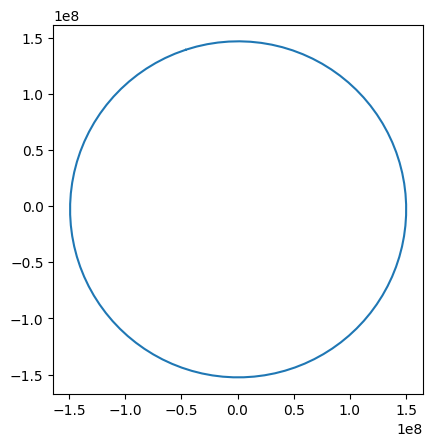

In [51]:
plt.plot(earth_positions[:,0], earth_positions[:,1])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [15]:

fireballs.to_csv('fireballs_integrate1.csv')

In [93]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=q, y=e, mode="markers"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=q, y=inc, mode="markers"),
    row=1, col=2
)
fig['layout']['xaxis']['title']='q [km]'
fig['layout']['xaxis2']['title']='q [km]'
fig['layout']['yaxis']['title']='e'
fig['layout']['yaxis2']['title']='i'
fig.update_layout(height=600, width=1000, title_text="Orbital Elements (e,q,inc) CNEOS data bolides integration one year")
fig.show()



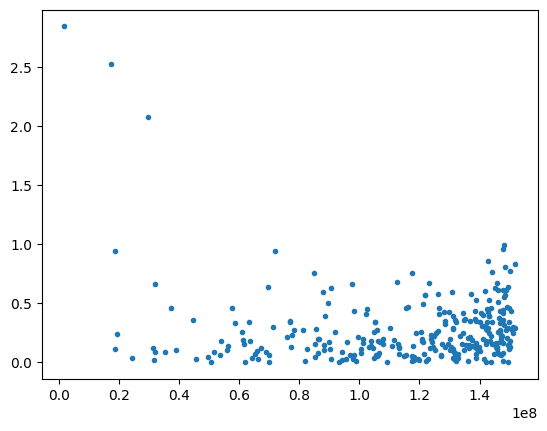

In [65]:
plt.plot(q, inc, '.')

In [63]:
import plotly.graph_objects as go

x, y, z = positions[:,0], positions[:,1], positions[:,2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [60]:
!pip install colorlover

Defaulting to user installation because normal site-packages is not writeable
